attempt to create ROIs to plug into FEAT

In [5]:
import os
import pandas as pd
import glob
import numpy as np
import nilearn
from nilearn import plotting
from nilearn import image
import nibabel as nib
import re
import shutil

somethings wrong with Ins harvard oxford masks - look into this

**tried in T1w spave but then ROIs and values are modfied when warping to MNI template which screws everything up

- define ROIs we want to use for ROI analysis in FSL FEAT
- use extracted signals data (using high passed)
- Maybe filter out confounds first? unsure if this matters
    - fsl_feat_roi_func does not have confounds filtered out
    - fsl_feat_roi_func does already have confounds filtered out
- fill MNI ROIs with uniform value from the ROI in extracted signal
- copy over MNI brain mask needed for FSL FEAT


In [6]:
# define functions
def find_rois(sub, dataset, atlas_name='ATAG', space='T1w'):
    if atlas_name == 'ATAG':
        mask_dir = f'../derivatives/masks_atag_func/{dataset}/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>[a-zA-Z0-9]+).nii.gz', fn).groupdict()['label'] for fn in fns]
    
    elif atlas_name == 'MASSP':
        mask_dir = f'../derivatives/masks_massp_func/{dataset}/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]
        
    elif atlas_name == 'harvard':
        mask_dir = f'../derivatives/masks_harvard_func/{dataset}/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>.*).nii.gz', fn).groupdict()['label'] for fn in fns]        

    roi_dict = dict(zip(names, fns))
    return roi_dict

def load_atlas(sub, dataset, atlas_name='MASSP', space='T1w'):
    from nilearn import image
    
    roi_dict = find_rois(sub, dataset, atlas_name, space)
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas

# def load_epi():
    
def get_epi(sub, dataset, task, run):

    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    epi = os.path.join(base_dir, f'sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz')
    return epi

def get_roi_masks(sub, dataset, task):
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/masks_useful_func/{dataset}/sub-{sub}/anat/*'))
    
    return masks

def get_default_epi(dataset):
    
    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    all_epis = sorted(glob.glob(os.path.join(base_dir, f'sub-*/func/sub-*_task-*_run-1_space-T1w_desc-preproc_bold.nii.gz')))
    
    return all_epis[0]

def get_default_roi_masks(dataset):
    default_epi = get_default_epi(dataset)
    default_sub = default_epi.split('/')[-3].split('-')[-1]
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/masks_useful_func/{dataset}/sub-{default_sub}/anat/*'))
    
    return masks

def load_events_confounds(sub, dataset, task, run, include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/{dataset}/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_events.tsv'
#    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
    confounds_fn = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    events['duration'] = .001
            
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement', 'global_signal']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
    if include_physio:
        run_idx = run#+1
        # just use acompcor
        a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        confounds = pd.concat([confounds, a_comp_cor], axis=1)

    return events, confounds


In [79]:
# # what ROIs?
# rois_ = [x.split('-mask-')[-1].split('.')[0] for x in glob.glob('/home/scotti/projects/3t_7t_sst_comparison/derivatives/masks_useful_func/NTNU_7T_SJSI/sub-002/anat/*')]

In [80]:
# # load the signals
# filter_out_confounds = True
# atlas_type = 'ALL'
# signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/aron_3T/sub-*/func/*task-*{atlas_type}-signals_hp.tsv'))
# regex = re.compile(f'.*/(?P<dataset>(.*?))/sub-.*/func/sub-(?P<sub>[a-zA-Z0-9]+)_task-(?P<task>\S+)_run-(?P<run>\d)_desc-ALL-signals_hp.tsv')

# for signal in signal_fns:
#     gd = regex.match(signal).groupdict()
#     dataset, sub, task, run = gd['dataset'], gd['sub'], gd['task'], gd['run']
#     print(dataset + ' ' + sub)
    
#     signal_load = pd.read_csv(signal, sep='\t',index_col=0).set_index('volume')
    
#     signal_load.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r', 'gpel':'gpe-l','gper':'gpe-r','gpil':'gpi-l','gpir':'gpi-r',
#                  'rnl':'rn-l','rnr':'rn-r','snl':'sn-l','snr':'sn-r','stnl':'stn-l','stnr':'stn-r',
#                  'strl':'str-l','strr':'str-r','thal':'tha-l','thar':'tha-r','vtal':'vta-l','vtar':'vta-r','rPreSMA':'preSMA-r','lPreSMA':'preSMA-l'}, inplace = True)
    
#     signal_load = signal_load[rois_]
    
#     # filter out confounds?
#     if filter_out_confounds:
#         _, confounds = load_events_confounds(sub=sub, dataset=dataset, task=task, run=run)
#         confounds['intercept'] = 1   # add intercept!
#         betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)
#         signals_hat = confounds@betas
#         signals_hat.index = signal_load.index
#         signals_hat.columns = signal_load.columns
# #         signal_load -= signals_hat   # residuals
#         signal_load = signals_hat.copy()   # -residuals
    
#     # load epi
#     this_epi = get_epi(sub,dataset,task,run) # just for saving
#     default_epi = get_default_epi(dataset) # return default epi 
#     load_epi = nib.load(default_epi)
#     epi_data = load_epi.get_fdata()
#     epi_data[:,:,:,:] = 0 # make all zeros
    
#     # save fn
#     save_fn = this_epi.replace('/fmriprep/fmriprep','').replace('fmriprep/','fsl_feat_roi_func_t1w/')
#     txt_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fsl_feat_roi_func_t1w/{dataset}/sub-{sub}/func/sub-{sub}_ROI_voxels.txt'
    
#     # load ROI masks
# #     these_masks = get_roi_masks(sub, dataset, task)
#     these_masks = get_default_roi_masks(dataset)
    
#     voxel_txt = []
#     # loop through masks
#     for this_mask in these_masks:
        
#         load_mask = nib.load(this_mask).get_fdata()
#         this_roi = this_mask.split('-mask-')[-1].split('.')[0] 
# #         print(this_roi)

#         if (num_voxels:=len(load_mask[load_mask>0.5])) == 0:
#             print(f'region {this_roi} in sub {sub}, {dataset} has no voxels above 50% probability')

#         voxel_txt.append(f'region {this_roi} has {num_voxels} above 50% probability') 
        
#         # loop through volumes
#         for vol, signal_ in enumerate(signal_load[this_roi].values.tolist()):
   
#             epi_data[:,:,:,vol][load_mask>0.5] = signal_
            
#     new_data = nib.nifti1.Nifti1Image(epi_data, affine = load_epi.affine)
#     os.makedirs(os.path.dirname(save_fn),exist_ok=True)
#     new_data.to_filename(save_fn)
#     with open(txt_fn, 'w') as fp:
#         for vox in voxel_txt:
#             # write each item on a new line
#             fp.write("%s\n" % vox)

aron_3T 01


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 01


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 01


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 02


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 02


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 02


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 03


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 03


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 03


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 04


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 04


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 04


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 05


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 05


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 05


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 06


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 06


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 06


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 07


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 07


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 07


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 09


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 09


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 09


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 10


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 10


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 10


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 11


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 11


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 12


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 12


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 13


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 13


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 13


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 14


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 14


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 14


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 15


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 15


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


aron_3T 15


/tmp/ipykernel_628292/1032701975.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)


### check the epi files

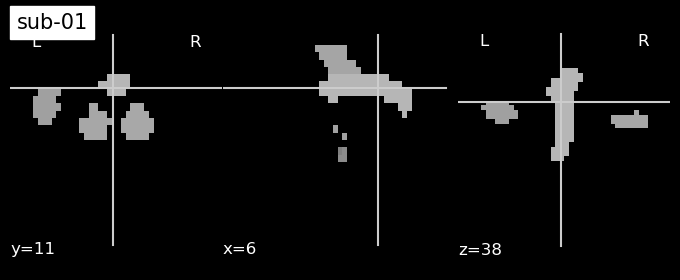

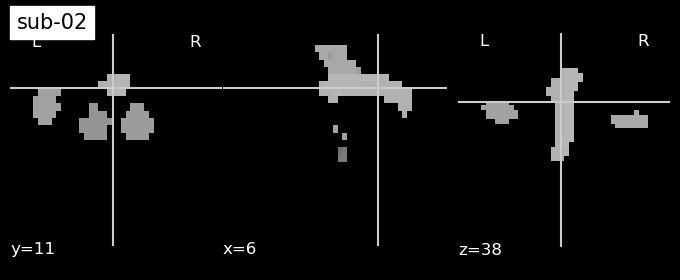

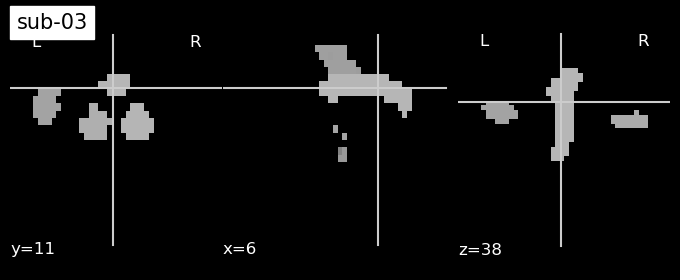

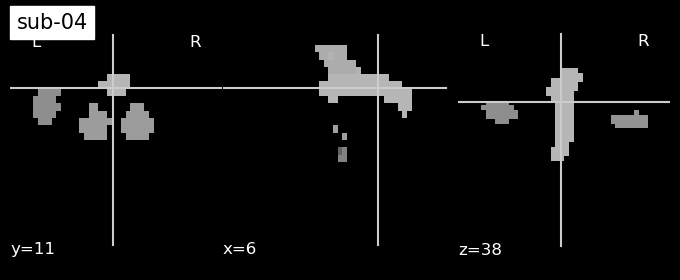

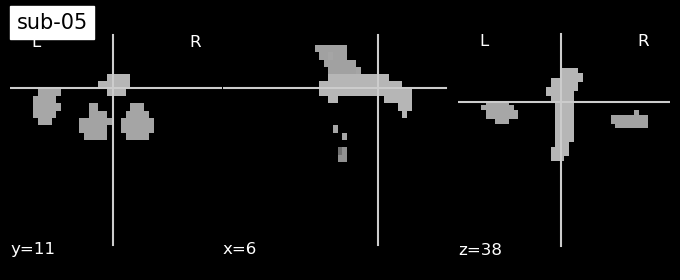

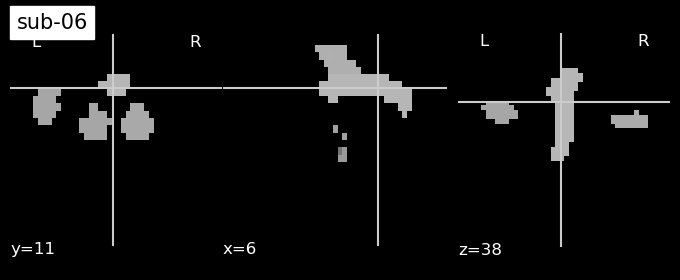

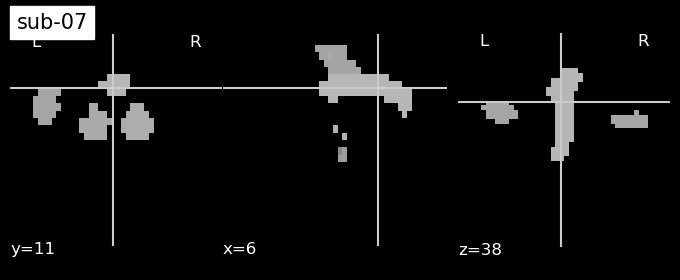

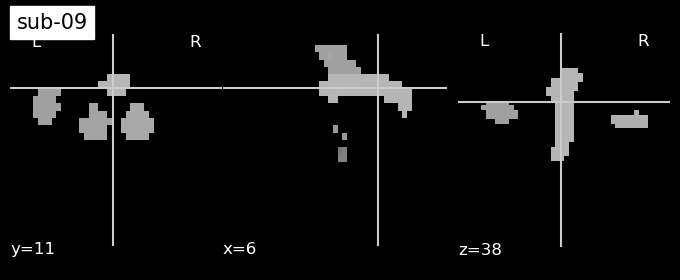

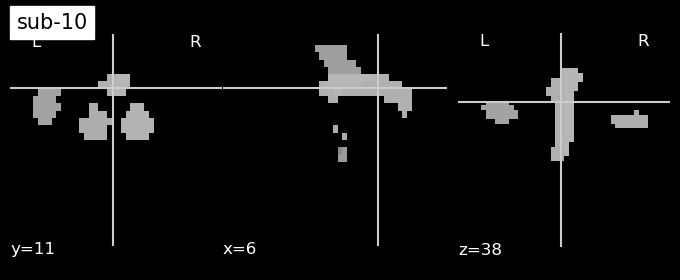

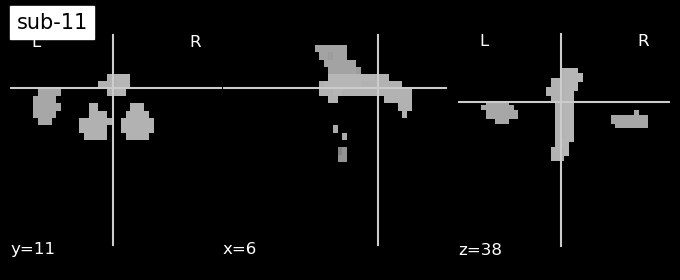

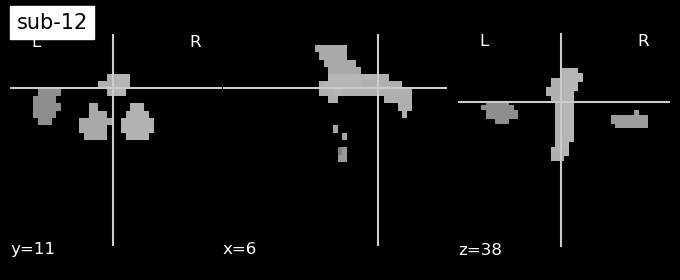

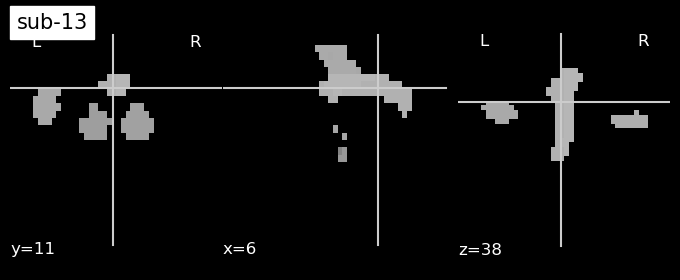

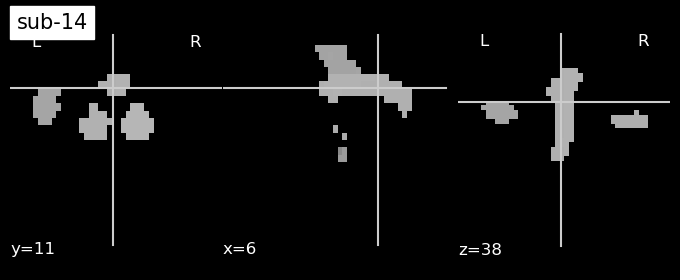

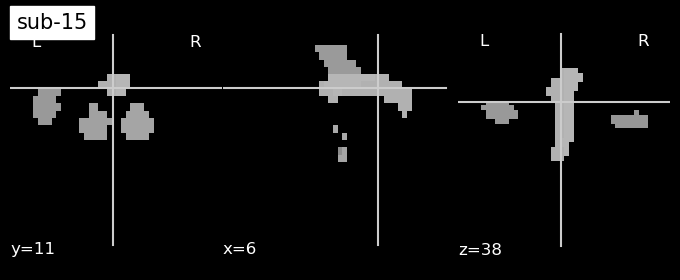

In [81]:
# check_fns = sorted(glob.glob('../derivatives/fsl_feat_roi_func_t1w/aron_3T/sub-*/func/sub-*_task-stopsignal_run-1_space-T1w_desc-preproc_bold.nii.gz'))

# for check in check_fns:
#     plotting.plot_anat(image.mean_img(check),title=check.split('/')[-3],cut_coords=(6,11,38))

good idea but now you need to copy h5, comp and mask files so that FSL FEAT registers everything correctly,
also need to rename everything and blah

In [82]:
# dataset = 'aron_3T'
# new_dir = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/{dataset}/'

# files_to_copy=[f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-01/anat/sub-01_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
# ,f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-1_space-T1w_desc-brain_mask.nii.gz'
# ,f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-2_space-T1w_desc-brain_mask.nii.gz'
# ,f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-3_space-T1w_desc-brain_mask.nii.gz'
# ,f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-1_from-scanner_to-T1w_mode-image_xfm.txt'
# ,f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-2_from-scanner_to-T1w_mode-image_xfm.txt'
# ,f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-3_from-scanner_to-T1w_mode-image_xfm.txt']

# subs = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob('/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/aron_3T/fmriprep/fmriprep/sub-*/'))]

In [83]:
# for sub in subs:
#     for file in files_to_copy:
#         if sub in ['11','12'] and 'run-3' in file:
#             print(f'skipping sub {sub} for file {file}')
                  
#         new_name = file.replace('/fmriprep/fmriprep/','/').replace('/fmriprep','/fmriprep_feat_hack').replace('sub-01',f'sub-{sub}')
# #         os.makedirs(os.path.dirname(new_name), exist_ok=True)
# #         shutil.copy(file,new_name)

skipping sub 11 for file /home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/aron_3T/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-3_space-T1w_desc-brain_mask.nii.gz
skipping sub 11 for file /home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/aron_3T/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-3_from-scanner_to-T1w_mode-image_xfm.txt
skipping sub 12 for file /home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/aron_3T/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-3_space-T1w_desc-brain_mask.nii.gz
skipping sub 12 for file /home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/aron_3T/fmriprep/fmriprep/sub-01/func/sub-01_task-stopsignal_run-3_from-scanner_to-T1w_mode-image_xfm.txt


In [428]:
# # okay replace brain mask with ROI functional image
# orig_img = nib.load('../derivatives/fsl_feat_roi_func_t1w/aron_3T/sub-01/func/sub-01_task-stopsignal_run-1_space-T1w_desc-preproc_bold.nii.gz')
# orig_data = orig_img.get_fdata()
# orig_data[orig_data>0] = 1
# mask_img = nib.nifti1.Nifti1Image(orig_data, affine=orig_img.affine)

# for sub in subs:
#     runs=[1,2] if sub in ['11','12'] else [1,2,3]
#     print(runs)
#     for run in runs:
#         save_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/{dataset}/sub-{sub}/func/sub-{sub}_task-stopsignal_run-{run}_space-T1w_desc-brain_mask.nii.gz'
#         print(save_fn)
#         mask_img.to_filename(save_fn)

[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-01/func/sub-01_task-stopsignal_run-1_space-T1w_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-01/func/sub-01_task-stopsignal_run-2_space-T1w_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-01/func/sub-01_task-stopsignal_run-3_space-T1w_desc-brain_mask.nii.gz
[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-02/func/sub-02_task-stopsignal_run-1_space-T1w_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-02/func/sub-02_task-stopsignal_run-2_space-T1w_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-02/func/sub-02_task-stopsignal_run-3_space-T1w_desc-brain_mask.nii.gz
[1, 2, 3]
/home/scotti/projects/3t_7t_sst_co

### ok this didnt work because registering to MNI smooths the data, need to start in MNI space

In [7]:
# what ROIs?
rois_ = [x.split('_label-')[-1].split('.')[0] for x in glob.glob('/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*')]
# rois_ = [x for x in rois_ if 'm1' not in x]

In [8]:
sorted(rois_)

['Caudate-l',
 'Caudate-r',
 'IFG-l',
 'IFG-r',
 'Putamen-l',
 'Putamen-r',
 'gpe-l',
 'gpe-r',
 'gpi-l',
 'gpi-r',
 'm1-l',
 'm1-r',
 'preSMA-l',
 'preSMA-r',
 'sn-l',
 'sn-r',
 'stn-l',
 'stn-r',
 'tha-l',
 'tha-r',
 'vta-l',
 'vta-r']

In [9]:
def get_epi(sub, dataset, task, run):

    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    epi = os.path.join(base_dir, f'sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_space-T1w_desc-preproc_bold.nii.gz')
    return epi

def get_roi_masks(sub, dataset, task):
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/masks_useful_func/{dataset}/sub-{sub}/anat/*'))
    
    return masks

def get_default_epi(dataset):
    
    base_dir = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep'
    all_epis = sorted(glob.glob(os.path.join(base_dir, f'sub-*/func/sub-*_task-*_run-1_space-T1w_desc-preproc_bold.nii.gz')))
    
    return all_epis[0]

def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
#     masks = [x for x in masks if 'm1' not in x]
    
    return masks

In [16]:
# load the signals
filter_out_confounds = False
overwrite = True
atlas_type = 'useful'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/*/sub-*/func/*task-*{atlas_type}-signals.tsv'))
# signal_fns = [x for x in signal_fns if any(s in x for s in ['10','11','12','13','14','15'])]
# signal_fns = [x for x in signal_fns if 'aron_3T' not in x]
regex = re.compile(f'.*/(?P<dataset>(.*?))/sub-.*/func/sub-(?P<sub>[a-zA-Z0-9]+)_task-(?P<task>\S+)_run-(?P<run>\d)_desc-useful-signals.tsv')

# make mni brain a 4d image
mni_brain = '/home/scotti/projects/3t_7t_sst_comparison/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
load_mni = nib.load(mni_brain)
mni_data = load_mni.get_fdata()

for signal in signal_fns:
    gd = regex.match(signal).groupdict()
    dataset, sub, task, run = gd['dataset'], gd['sub'], gd['task'], gd['run']
    print(dataset + ' ' + sub)
    
    signal_load = pd.read_csv(signal, sep='\t',index_col=0)#.set_index('volume')
    
#     signal_load.rename(columns = {'lM1':'m1-l', 'rM1':'m1-r', 'gpel':'gpe-l','gper':'gpe-r','gpil':'gpi-l','gpir':'gpi-r',
#                  'rnl':'rn-l','rnr':'rn-r','snl':'sn-l','snr':'sn-r','stnl':'stn-l','stnr':'stn-r',
#                  'strl':'str-l','strr':'str-r','thal':'tha-l','thar':'tha-r','vtal':'vta-l','vtar':'vta-r','rPreSMA':'preSMA-r','lPreSMA':'preSMA-l'}, inplace = True)
    signal_load.rename(columns = {'M1-l':'m1-l', 'M1-r':'m1-r'}, inplace=True)
    signal_load = signal_load[rois_]
    
#     # filter out confounds?
#     if filter_out_confounds:
#         print('filtering confounds..')
#         _, confounds = load_events_confounds(sub=sub, dataset=dataset, task=task, run=run)
#         confounds['intercept'] = 1   # add intercept!
#         betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signal_load)
#         signals_hat = confounds@betas
#         signals_hat.index = signal_load.index
#         signals_hat.columns = signal_load.columns
# #         signal_load -= signals_hat   # residuals
#         signal_load = signals_hat.copy()   # -residuals    

    # load epi
    this_epi = get_epi(sub,dataset,task,run) # just for saving
#     default_epi = get_default_epi(dataset) # return default epi 
#     load_epi = nib.load(default_epi)
#     epi_data = load_epi.get_fdata()
#     epi_data[:,:,:,:] = 0 # make all zeros
    epi_data = np.zeros((mni_data.shape + (len(signal_load),)))
    
    # save fn
    save_fn = this_epi.replace('/fmriprep/fmriprep','').replace('fmriprep/','fsl_feat_roi_func/').replace('space-T1w','space-MNI152NLin2009cAsym')
    
    # overwrite yes or no?
    if not overwrite and os.path.exists(save_fn):
        print(save_fn)
        print('already exists and not overwriting.. ')
        continue
    
    txt_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fsl_feat_roi_func/{dataset}/sub-{sub}/func/sub-{sub}_ROI_voxels.txt'
    print(save_fn)
    # load ROI masks
#     these_masks = get_roi_masks(sub, dataset, task)
    these_masks = get_mni_roi_masks()
    
    voxel_txt = []
    # loop through masks
    for this_mask in these_masks:
        
        load_mask = nib.load(this_mask).get_fdata()
        this_roi = this_mask.split('_label-')[-1].split('.')[0] 
        print(this_roi)

        if (num_voxels:=len(load_mask[load_mask>0.5])) == 0:
            print(f'region {this_roi} in sub {sub}, {dataset} has no voxels above 50% probability')

        voxel_txt.append(f'region {this_roi} has {num_voxels} above 50% probability') 
        
        # loop through volumes
        for vol, signal_ in enumerate(signal_load[this_roi].values.tolist()):
   
            epi_data[:,:,:,vol][load_mask>0.5] = signal_
            
    new_data = nib.nifti1.Nifti1Image(epi_data, affine = load_mni.affine)
    os.makedirs(os.path.dirname(save_fn),exist_ok=True)
    new_data.to_filename(save_fn)
    with open(txt_fn, 'w') as fp:
        for vox in voxel_txt:
            # write each item on a new line
            fp.write("%s\n" % vox)

Leipzig_7T_GdH BI3T
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-BI3T/func/sub-BI3T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_GdH BI3T
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-BI3T/func/sub-BI3T_task-stop_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_GdH BI3T
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-BI3T/func/sub-BI3T_task-stop_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_GdH FMFT
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-FMFT

Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_GdH RSIT
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-RSIT/func/sub-RSIT_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_GdH RSIT
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-RSIT/func/sub-RSIT_task-stop_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_GdH RSIT
../derivatives/fsl_feat_roi_func/Leipzig_7T_GdH/sub-RSIT/func/sub-RSIT_task-stop_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l

Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_SM 02
../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-02/func/sub-02_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_SM 02
../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-02/func/sub-02_task-stop_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_SM 02
../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-02/func/sub-02_task-stop_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
s

sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_SM 13
../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-13/func/sub-13_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_SM 13
../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-13/func/sub-13_task-stop_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_SM 13
../derivatives/fsl_feat_roi_func/Leipzig_7T_SM/sub-13/func/sub-13_task-stop_run-3_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
Leipzig_7T_SM 15
../derivatives/fsl_feat_roi_func/Leip

Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
NTNU_7T_SJSI 012
../derivatives/fsl_feat_roi_func/NTNU_7T_SJSI/sub-012/func/sub-012_task-sst_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
NTNU_7T_SJSI 012
../derivatives/fsl_feat_roi_func/NTNU_7T_SJSI/sub-012/func/sub-012_task-sst_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
NTNU_7T_SJSI 014
../derivatives/fsl_feat_roi_func/NTNU_7T_SJSI/sub-014/func/sub-014_task-sst_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
s

sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
NTNU_7T_SJSI 031
../derivatives/fsl_feat_roi_func/NTNU_7T_SJSI/sub-031/func/sub-031_task-sst_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
NTNU_7T_SJSI 032
../derivatives/fsl_feat_roi_func/NTNU_7T_SJSI/sub-032/func/sub-032_task-sst_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
NTNU_7T_SJSI 032
../derivatives/fsl_feat_roi_func/NTNU_7T_SJSI/sub-032/func/sub-032_task-sst_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
Caudate-l
Caudate-r
IFG-l
IFG-r
Putamen-l
Putamen-r
gpe-l
gpe-r
gpi-l
gpi-r
m1-l
m1-r
preSMA-l
preSMA-r
sn-l
sn-r
stn-l
stn-r
tha-l
tha-r
vta-l
vta-r
NTNU_7T_SJSI 033
../derivatives/fsl_feat_roi_func/NTNU

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



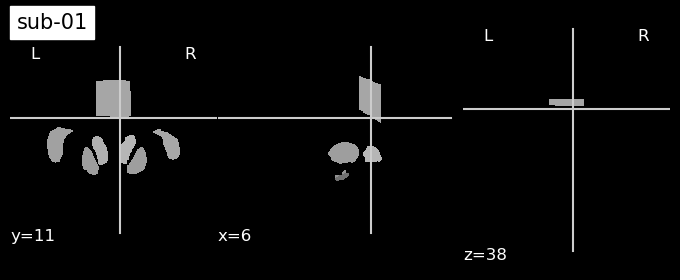

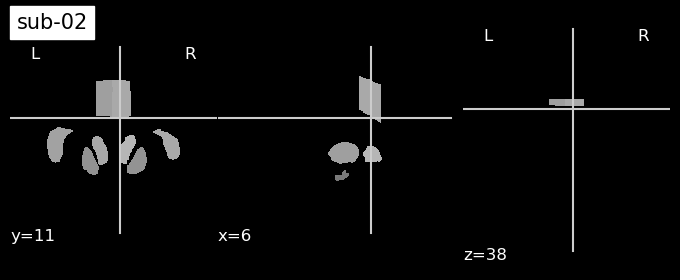

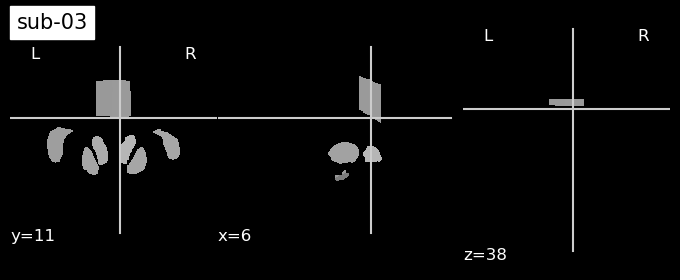

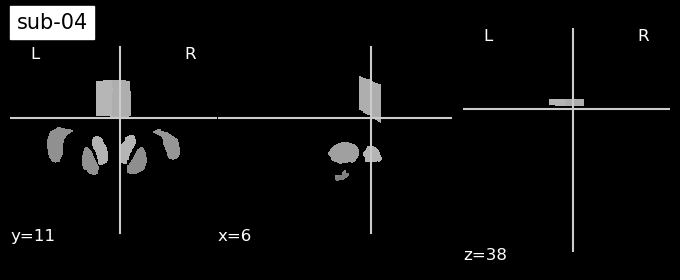

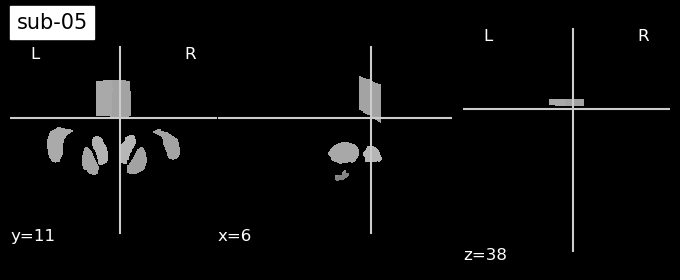

In [17]:
check_fns = sorted(glob.glob('../derivatives/fsl_feat_roi_func/aron_3T/sub-*/func/sub-*_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))

for check in check_fns[:5]:
    plotting.plot_anat(image.mean_img(check),title=check.split('/')[-3],cut_coords=(6,11,38))

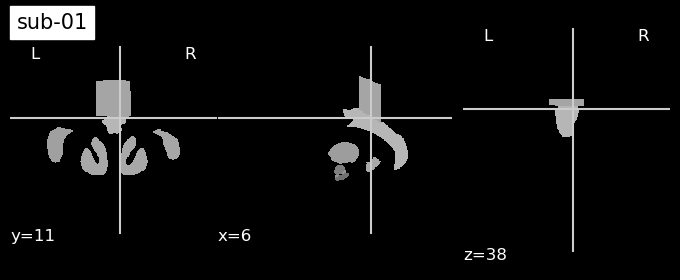

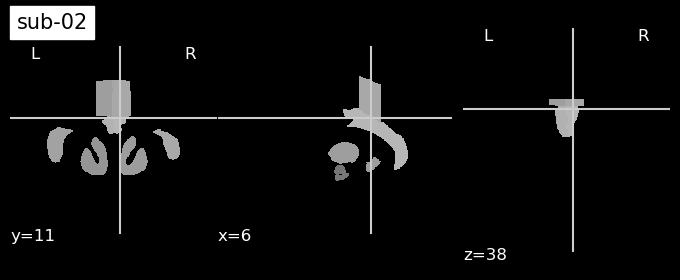

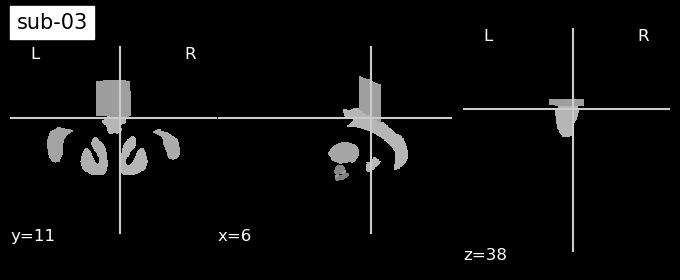

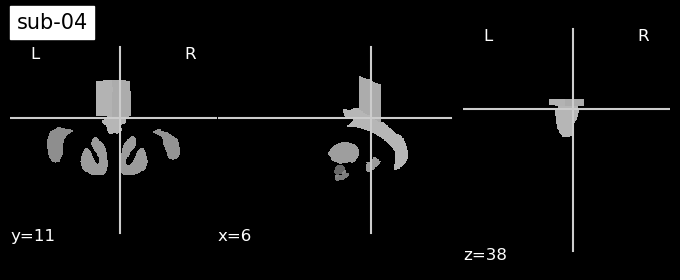

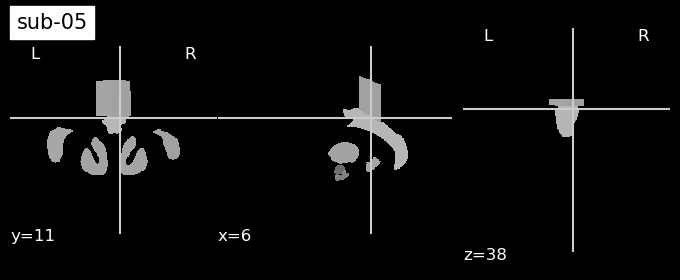

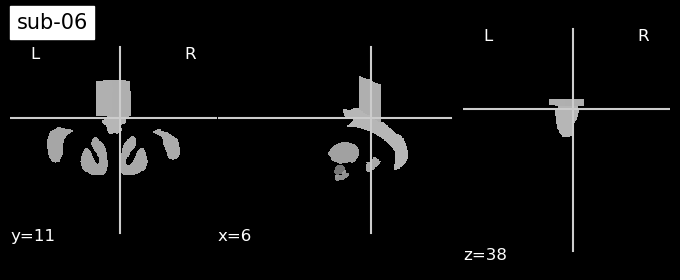

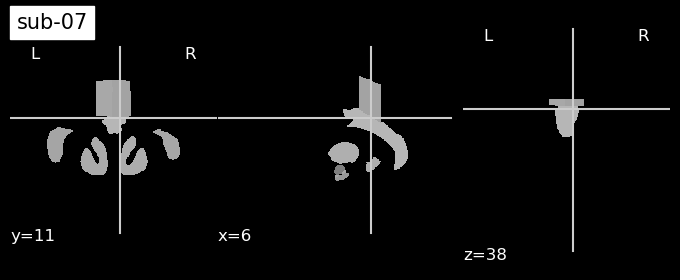

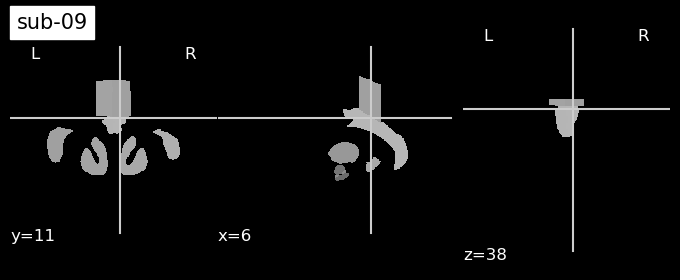

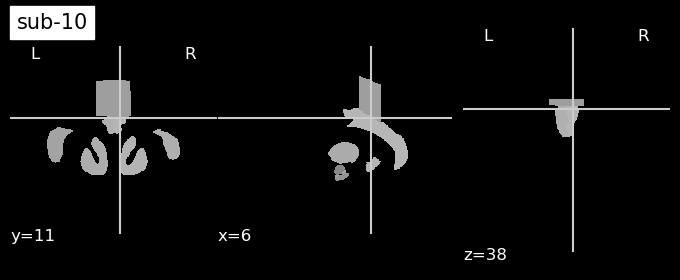

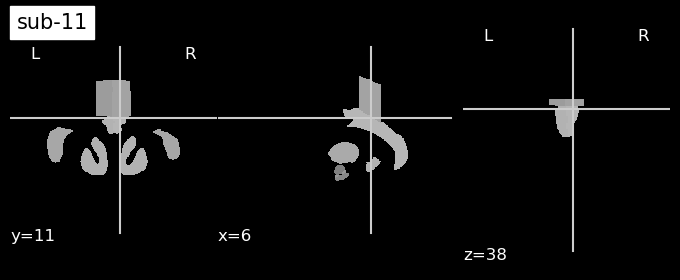

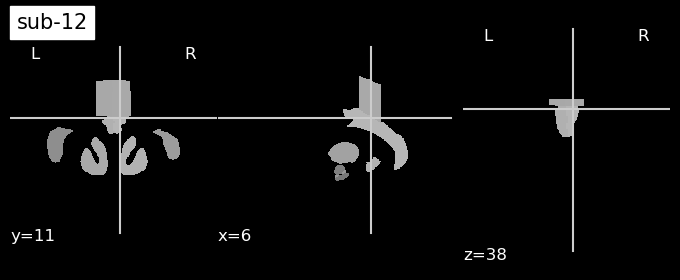

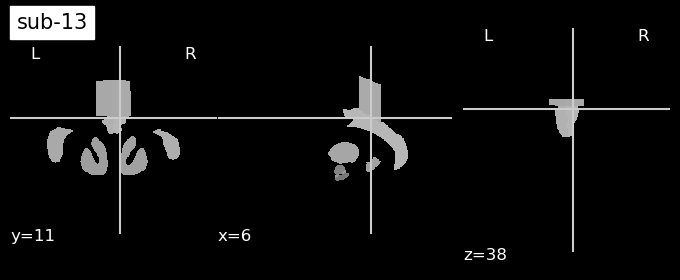

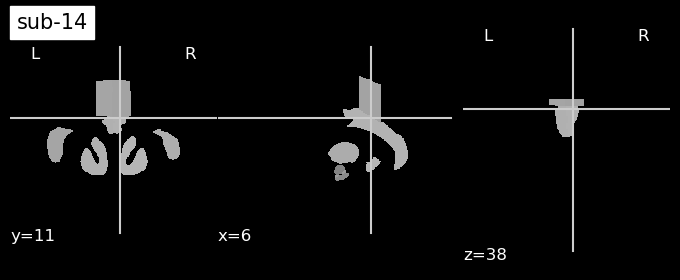

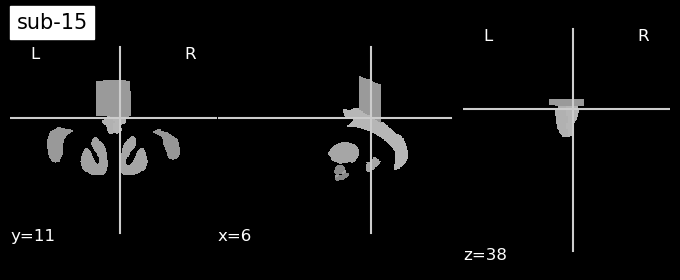

In [23]:
check_fns = sorted(glob.glob('../derivatives/fsl_feat_roi_func/aron_3T/sub-*/func/sub-*_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))

for check in check_fns:
    plotting.plot_anat(image.mean_img(check),title=check.split('/')[-3],cut_coords=(6,11,38))

In [6]:
# must also copy brain mask over again, but this time mni one
dataset = 'aron_3T'
subs = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-*/'))]
orig_img = nib.load(f'../derivatives/fsl_feat_roi_func/{dataset}/sub-01/func/sub-01_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
orig_data = orig_img.get_fdata()
orig_data[orig_data>0] = 1
mask_img = nib.nifti1.Nifti1Image(orig_data, affine=orig_img.affine)

for sub in subs:
    runs=[1,2] if sub in ['11','12'] else [1,2,3]
    print(runs)
    for run in runs:
        save_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/{dataset}/sub-{sub}/func/sub-{sub}_task-stopsignal_run-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        print(save_fn)
        os.makedirs(os.path.dirname(save_fn),exist_ok=True)
        mask_img.to_filename(save_fn)

[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-01/func/sub-01_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-01/func/sub-01_task-stopsignal_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-01/func/sub-01_task-stopsignal_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-02/func/sub-02_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-02/func/sub-02_task-stopsignal_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/aron_3T/sub-02/func/sub-02_task-stopsignal_run

In [6]:
# must also copy brain mask over again, but this time mni one
dataset = 'Leipzig_7T_GdH'
subs = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-*/'))]
orig_img = nib.load(f'../derivatives/fsl_feat_roi_func/{dataset}/sub-BI3T/func/sub-BI3T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
orig_data = orig_img.get_fdata()
orig_data[orig_data>0] = 1
mask_img = nib.nifti1.Nifti1Image(orig_data, affine=orig_img.affine)

for sub in subs:
    runs=[1,2] if sub in ['DA9T'] else [1,2,3]
    print(runs)
    for run in runs:
        save_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/{dataset}/sub-{sub}/func/sub-{sub}_task-stop_run-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        print(save_fn)
        os.makedirs(os.path.dirname(save_fn),exist_ok=True)
        mask_img.to_filename(save_fn)

[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-BI3T/func/sub-BI3T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-BI3T/func/sub-BI3T_task-stop_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-BI3T/func/sub-BI3T_task-stop_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-FMFT/func/sub-FMFT_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-FMFT/func/sub-FMFT_task-stop_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-FM

/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-WW2T/func/sub-WW2T_task-stop_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-WW2T/func/sub-WW2T_task-stop_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-ZK4T/func/sub-ZK4T_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-ZK4T/func/sub-ZK4T_task-stop_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_GdH/sub-ZK4T/func/sub-ZK4T_task-stop_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


In [7]:
# must also copy brain mask over again, but this time mni one
dataset = 'Leipzig_7T_SM'
subs = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-*/'))]
orig_img = nib.load(f'../derivatives/fsl_feat_roi_func/{dataset}/sub-01/func/sub-01_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
orig_data = orig_img.get_fdata()
orig_data[orig_data>0] = 1
mask_img = nib.nifti1.Nifti1Image(orig_data, affine=orig_img.affine)

for sub in subs:
    runs=[1,2] if sub in ['17'] else [1,2,3]
    print(runs)
    for run in runs:
        save_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/{dataset}/sub-{sub}/func/sub-{sub}_task-stop_run-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        print(save_fn)
        os.makedirs(os.path.dirname(save_fn),exist_ok=True)
        mask_img.to_filename(save_fn)

[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_SM/sub-01/func/sub-01_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_SM/sub-01/func/sub-01_task-stop_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_SM/sub-01/func/sub-01_task-stop_run-3_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2, 3]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_SM/sub-02/func/sub-02_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_SM/sub-02/func/sub-02_task-stop_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/Leipzig_7T_SM/sub-02/func/sub-02_task-stop_run

In [8]:
# must also copy brain mask over again, but this time mni one
dataset = 'NTNU_7T_SJSI'
subs = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-*/'))]
orig_img = nib.load(f'../derivatives/fsl_feat_roi_func/{dataset}/sub-002/func/sub-002_task-sst_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
orig_data = orig_img.get_fdata()
orig_data[orig_data>0] = 1
mask_img = nib.nifti1.Nifti1Image(orig_data, affine=orig_img.affine)

for sub in subs:
    runs=[1] if sub in ['040'] else [1,2]
    print(runs)
    for run in runs:
        save_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/{dataset}/sub-{sub}/func/sub-{sub}_task-sst_run-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        print(save_fn)
        os.makedirs(os.path.dirname(save_fn),exist_ok=True)
        mask_img.to_filename(save_fn)

[1, 2]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-002/func/sub-002_task-sst_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-002/func/sub-002_task-sst_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-003/func/sub-003_task-sst_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-003/func/sub-003_task-sst_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-005/func/sub-005_task-sst_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-005/func/sub-005_task-sst_ru

/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-034/func/sub-034_task-sst_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-035/func/sub-035_task-sst_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-035/func/sub-035_task-sst_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-037/func/sub-037_task-sst_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-037/func/sub-037_task-sst_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1, 2]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/NTNU_7T_SJSI/sub-038/func/sub-038_task-sst_ru

In [9]:
# must also copy brain mask over again, but this time mni one
dataset = 'openfmri_3T'
subs = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-*/'))]
orig_img = nib.load(f'../derivatives/fsl_feat_roi_func/{dataset}/sub-10871/func/sub-10871_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
orig_data = orig_img.get_fdata()
orig_data[orig_data>0] = 1
mask_img = nib.nifti1.Nifti1Image(orig_data, affine=orig_img.affine)

for sub in subs:
    runs=[1]
    print(runs)
    for run in runs:
        save_fn = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/{dataset}/sub-{sub}/func/sub-{sub}_task-stopsignal_run-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        print(save_fn)
        os.makedirs(os.path.dirname(save_fn),exist_ok=True)
        mask_img.to_filename(save_fn)

[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10159/func/sub-10159_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10171/func/sub-10171_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10206/func/sub-10206_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10217/func/sub-10217_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10228/func/sub-10228_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_fe

[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10629/func/sub-10629_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10631/func/sub-10631_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10638/func/sub-10638_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10668/func/sub-10668_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-10674/func/sub-10674_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_fe

[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-11104/func/sub-11104_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-11108/func/sub-11108_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-11128/func/sub-11128_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-11131/func/sub-11131_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_feat_hack/openfmri_3T/sub-11143/func/sub-11143_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
[1]
/home/scotti/projects/3t_7t_sst_comparison/derivatives/fmriprep_fe

# old method

## create ROIs made up of just the mean signal of that ROI

In [267]:
atlas_type = 'ALL'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/*/sub-*/func/*task-*{atlas_type}-signals.tsv'))
regex = re.compile(f'.*/(?P<dataset>(.*?))/sub-.*/func/sub-(?P<sub>[a-zA-Z0-9]+)_task-(?P<task>\S+)_run-(?P<run>\d)_desc-ALL-signals.tsv')

aff = np.array(((1,0,0,0),(0,1,0,0),(0,0,1,0),(0,0,0,1)))
save_dir = f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_for_feat'

for signal in signal_fns:
    gd = regex.match(signal).groupdict()
    dataset, sub, run = gd['dataset'], gd['sub'], gd['run']
    
    signal_load = pd.read_csv(signal, sep='\t',index_col=0).set_index('volume')
    
    signal_load.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r', 'gpel':'GPe-l','gper':'GPe-r','gpil':'GPi-l','gpir':'GPi-r',
                     'rnl':'RN-l','rnr':'RN-r','snl':'SN-l','snr':'SN-r','stnl':'STN-l','stnr':'STN-r',
                     'strl':'Str-l','strr':'Str-r','thal':'Tha-l','thar':'Tha-r','vtal':'VTA-l','vtar':'VTA-r','rPreSMA':'preSMA-r','lPreSMA':'preSMA-l'}, inplace = True)
    
    rois_ = ['IFG','preSMA','M1','SN','STN','GPe','GPi','Tha']
    rois_ = [roi + '-' + hemi for roi in rois_ for hemi in ['l', 'r']]
    
    signal_load = signal_load[rois_]
    
    for roi in signal_load.columns:
        roi_signal = signal_load[roi].values.tolist()
        mat = np.zeros((3,3,3,signal_load.shape[0]))
        for i, val in enumerate(roi_signal):
            mat[:,:,:,i] = val

            nib_img = nib.nifti1.Nifti1Image(mat, affine=aff)

        # save image
        os.makedirs(os.path.dirname(save_fn:=os.path.join(save_dir, dataset, f'sub-{sub}', 'func', f'{dataset}_sub-{sub}_run-{run}_{roi}.nii.gz')),exist_ok=True)
        nib_img.to_filename(save_fn)

## create a 'template' to input to fsl feat

In [ ]:
template = np.zeros((3,3,3))
template_affine = np.array(((1,0,0),(0,1,0),(0,0,1)))
template_img = nib.nifti1.Nifti1Image(template, affine=template_affine).to_filename('/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_for_feat/template_brain.nii.gz')
